# Практическая работа № 2. Логистическая регрессия

## 1. Бинарная классификация. Случай линейно разделимых классов

Классификация с бинарной переменной класса, т.е. категориальной выходной переменной, которая может принимать только два значения. Классы могут максимально точно разделиться на две группы.

### Подключение библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sklearn.preprocessing as pp

from sklearn import linear_model

Основные функции


*   Сигмоида - sigmoid
*   costFunction
*   gradientFunc



In [ ]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def costFunction(theta, X, y):
    h = sigmoid(np.dot(X, theta))
    J = -(1.0 / len(y)) * (y * np.transpose(np.log(h)) + (1 - y) * np.transpose(np.log(1 - h))).sum()
    return J

def gradientFunc(theta, X, y):
    alpha = sigmoid(np.dot(X, theta))
    grad = (1.0 / len(y)) * np.dot(alpha.T - y, X).T
    return grad

Подгрузка данных

In [ ]:
df = pd.read_table("/content/ex2data1.txt", header = None, delimiter= ",",names=["Exam_1", "Exam_2","Admited"])
df.head()

,Exam_1,Exam_2,Admited
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Подготовка набора данных

In [ ]:
dff = np.array(df)
X = dff[:,:2]             # Exam_1, Exam_2
y = dff[:,2]              # Admited
theta = np.zeros((3, 1))
ones = np.ones(X.size)

m, n = X.shape
X_ = np.column_stack((np.ones((m,1)), X))

График зависимости поступления студентов
Было проведено разделение набора данных на 2 в зависимости от значения целевого признака


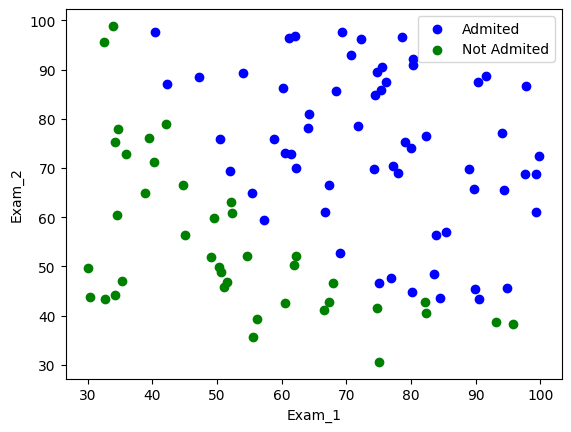

In [ ]:
Admited = df.loc[df['Admited'] == 1]
Not_admited = df.loc[df['Admited'] == 0]

A = np.array(Admited)[:,:2]
NA = np.array(Not_admited)[:,:2]

plt.scatter(A[:,0], A[:,1], color = 'b', label = "Admited");
plt.scatter(NA[:,0], NA[:,1], color = 'g', label = "Not Admited");

plt.xlabel('Exam_1')
plt.ylabel('Exam_2')
plt.legend()
plt.show()

Проверка работы стоимостной функции на данных из набора

In [ ]:
costFunction(theta, X_, y)

0.6931471805599453

Проверка работы функции градиента на данных из набора

In [ ]:
gradientFunc(theta, X_, y)

array([[ -0.1       ],
       [-12.00921659],
       [-11.26284221]])

Реализация метода Ньютона сопряженных градиентов из пакета Scipy

С помощью этого метода были получены оптимальные значения весов после обучения

In [ ]:
import scipy.optimize as opt
result = opt.fmin_tnc(func = costFunction,
 x0 = theta, fprime = gradientFunc,
 args = (X_, y))
theta_optimized = result[0]
print(theta_optimized)

[-25.16131857   0.20623159   0.20147149]


Построение графика полученной функции, а так же добавление на график данных студента Х (45, 85)

# Сделать границу кривой

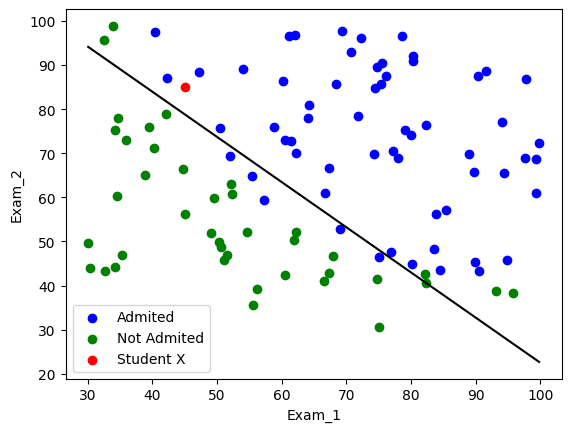

In [ ]:
Admited = df.loc[df['Admited'] == 1]
Not_admited = df.loc[df['Admited'] == 0]
Student_XE1 = 45
Student_XE2 = 85
A = np.array(Admited)[:,:2]
NA = np.array(Not_admited)[:,:2]

plt.scatter(A[:,0], A[:,1], color = 'b', label = "Admited");
plt.scatter(NA[:,0], NA[:,1], color = 'g', label = "Not Admited");
plt.scatter(Student_XE1, Student_XE2, color = 'r', label = "Student X");

x_values  = np.linspace(min(min(X[:,0]),min(X[:,1])), max(max(X[:,0]),max(X[:,1])), 100)
y_values = (-1.0 / theta_optimized[2]) * (theta_optimized[1] * x_values + theta_optimized[0])
plt.plot(x_values, y_values, color = 'black')

plt.xlabel('Exam_1')
plt.ylabel('Exam_2')
plt.legend()
plt.show()

Предсказание данных студента


In [ ]:
a = round(sigmoid(np.dot(np.array((1, Student_XE1, Student_XE2)), theta_optimized)), )
if a == 1:
  print("Admited")
else: print("Not Admited")

Admited


Проверка точности модели c помощью метода R^2, который определяет процент дисперсии процент дисперсии в поле назначения, объясняемый одной или несколькими входными переменными.

In [ ]:
predictions = sigmoid(np.dot(np.array((1, X[:,0], X[:,1])), theta_optimized))
errors = predictions - y
sse = np.sum(errors ** 2)
r2 = 1 - sse / (y.size * y.var())
print("R-squared:", round(r2, 3))

R-squared: 0.724


<ipython-input-182-5e72bbc03fc2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = sigmoid(np.dot(np.array((1, X[:,0], X[:,1])), theta_optimized))


## 2. Бинарная классификация. Случай не разделимых линейно классов


## Загрузка данных

In [ ]:
df = pd.read_table("/content/ex2data2.txt", header = None, delimiter= ",",names=["Test_1", "Test_2","Pass"])
df.head()

,Test_1,Test_2,Pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Основные функции, с добавлениеем регуляризации

*   Сигмоида - sigmoid
*   costFunction
*   gradientFunc



In [ ]:
def costFunctionR(theta, X, y, lam):
    alpha = sigmoid(np.dot(X, theta))
    return costFunction(theta, X, y) + (float(lam) / (2 * len(y))) * np.power(theta, 2).sum()

def gradientFuncR(theta, X, y, lam):
    alpha = sigmoid(np.dot(X, theta))
    return (1.0 / len(y)) * np.dot(alpha.T - y, X).T + (float(lam) / len(y)) * theta

def polinomy(x1, x2, level):
  out = np.ones(x1.shape[0])
  for i in range(1,level+1):
    for j in range(0,i+1):
      out = np.c_[out, np.power(x1, i-j)*np.power(x2, j)]
  return out

Подготовка набора данных

In [ ]:
dff = np.array(df)
X = dff[:,:2]             # Test_1, Test_2
y = dff[:,2]              # Pass
theta = np.zeros((28, 1))
ones = np.ones(X.size)

m, n = X.shape
X_ = np.column_stack((np.ones((m,1)), X))

График зависимости качества чипов


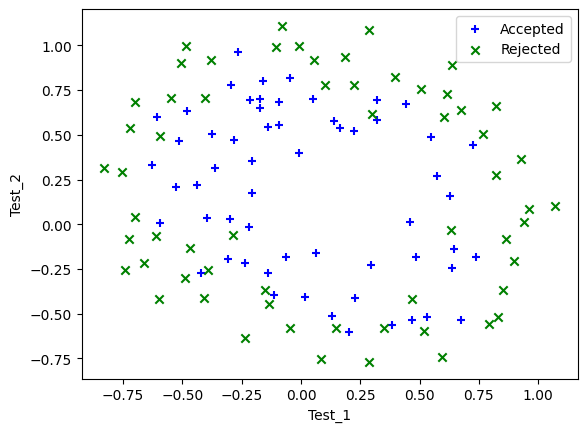

In [ ]:
Accepted = df.loc[df['Pass'] == 1]
Rejected = df.loc[df['Pass'] == 0]

A = np.array(Accepted)[:,:2]
R = np.array(Rejected)[:,:2]

plt.scatter(A[:,0], A[:,1], color = 'b', label = "Accepted", marker='+');
plt.scatter(R[:,0], R[:,1], color = 'g', label = "Rejected", marker='x');

plt.xlabel('Test_1')
plt.ylabel('Test_2')
plt.legend()
plt.show()

Добавление полиномиальных признаков

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 6)
X_poly = poly.fit_transform(X)

Стоимостная функция

In [ ]:
costFunctionR(theta, X_poly, y, 1)

0.6931471805599454

Фунцкия градиента

In [ ]:
gradientFuncR(theta, X_poly, y, 1)

array([[8.47457627e-03],
       [1.87880932e-02],
       [7.77711864e-05],
       [5.03446395e-02],
       [1.15013308e-02],
       [3.76648474e-02],
       [1.83559872e-02],
       [7.32393391e-03],
       [8.19244468e-03],
       [2.34764889e-02],
       [3.93486234e-02],
       [2.23923907e-03],
       [1.28600503e-02],
       [3.09593720e-03],
       [3.93028171e-02],
       [1.99707467e-02],
       [4.32983232e-03],
       [3.38643902e-03],
       [5.83822078e-03],
       [4.47629067e-03],
       [3.10079849e-02],
       [3.10312442e-02],
       [1.09740238e-03],
       [6.31570797e-03],
       [4.08503006e-04],
       [7.26504316e-03],
       [1.37646175e-03],
       [3.87936363e-02]])

Минимизация функции

In [ ]:
import scipy.optimize as opt
result = opt.fmin_tnc(func = costFunctionR,
 x0 = theta, fprime = gradientFuncR,
 args = (X_poly, y, 1))
theta_optimized = result[0]
print(theta_optimized)

[ 1.1420156   0.6012371   1.16715835 -1.87180893 -0.91567143 -1.26944037
  0.1267866  -0.36850119 -0.34494267 -0.17391062 -1.42370675 -0.0483859
 -0.60631735 -0.26916592 -1.16320198 -0.24269729 -0.2069749  -0.04305271
 -0.28008554 -0.28708923 -0.4691246  -1.03629758  0.02904389 -0.29250733
  0.01716387 -0.32880523 -0.13795621 -0.93187584]


График полиномиальной регрессии на двух переменных.

Сначала создается массив u, который содержит значения первой переменной из отрезка [-1, 1.5] с шагом 0.5. Затем создается массив v, который содержит значения второй переменной из того же отрезка с шагом 0.5.

Далее создается массив z, который будет содержать значения полиномиальной регрессии для всех пар значений u и v. Затем происходит перебор всех значений u и v, и для каждой пары вычисляется значение полиномиальной регрессии, используя функцию polinomy и массив theta_optimized, который содержит оптимизированные коэффициенты полиномиальной регрессии.

Затем значения полиномиальной регрессии для всех пар значений u и v записываются в массив z.

Наконец, массив z транспонируется, чтобы получить двумерный массив, содержащий значения полиномиальной регрессии для всех пар значений u и v. Затем этот массив используется для построения контура графика с помощью функции plt.contour.

В данном случае контур графика содержит только ось y=0, так как мы передаем в функцию plt.contour только один уровень (0), на котором нужно построить контур.

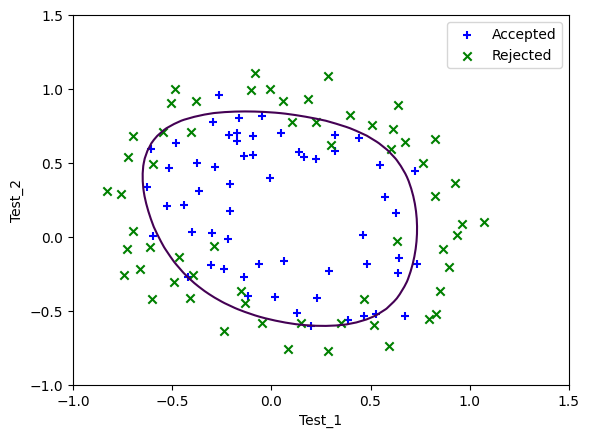

In [ ]:
Accepted = df.loc[df['Pass'] == 1]
Rejected = df.loc[df['Pass'] == 0]

A = np.array(Accepted)[:,:2]
R = np.array(Rejected)[:,:2]

plt.scatter(A[:,0], A[:,1], color = 'b', label = "Accepted", marker='+');
plt.scatter(R[:,0], R[:,1], color = 'g', label = "Rejected", marker='x');


u = np.linspace(-1.0, 1.5, num=50)
v = np.linspace(-1.0, 1.5, num=50)
z = np.zeros((u.size, v.size))

for i in range(len(u)):
    for j in range(len(v)):
            z[i,j] = np.dot(polinomy(np.array([u[i]]), np.array([v[j]]), 6), theta_optimized)

z = np.transpose(z)

plt.contour(u, v, z, levels=[0]).collections[0]


plt.xlabel('Test_1')
plt.ylabel('Test_2')
plt.legend()
plt.show(block=False)




Недообученная сеть

Если параметр регуляризации слишком маленький, то модель может не учитывать важные признаки и не дать достаточно точного предсказания. Поэтому выбор параметра регуляризации является важной задачей, и его значение должно быть оптимизировано на обучающей выборке.

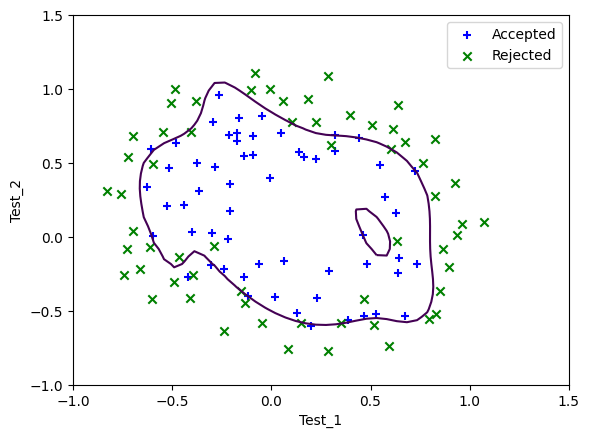

In [ ]:
import scipy.optimize as opt
result = opt.fmin_tnc(func = costFunctionR,
 x0 = theta, fprime = gradientFuncR,
 args = (X_poly, y, 0))
theta_optimized = result[0]

Accepted = df.loc[df['Pass'] == 1]
Rejected = df.loc[df['Pass'] == 0]

A = np.array(Accepted)[:,:2]
R = np.array(Rejected)[:,:2]

plt.scatter(A[:,0], A[:,1], color = 'b', label = "Accepted", marker='+');
plt.scatter(R[:,0], R[:,1], color = 'g', label = "Rejected", marker='x');


u = np.linspace(-1.0, 1.5, num=50)
v = np.linspace(-1.0, 1.5, num=50)
z = np.zeros((u.size, v.size))

for i in range(len(u)):
    for j in range(len(v)):
            z[i,j] = np.dot(polinomy(np.array([u[i]]), np.array([v[j]]), 6), theta_optimized)

z = np.transpose(z)

plt.contour(u, v, z, levels=[0]).collections[0]


plt.xlabel('Test_1')
plt.ylabel('Test_2')
plt.legend()
plt.show(block=False)

Переобученная сеть

Переобучение произошло из-за увеличения параметра регуляризации до 100

Переобучение может зависеть от параметра регуляризации, так как регуляризация добавляет штраф к коэффициентам модели, чтобы уменьшить переобучение.

Если параметр регуляризации слишком большой, то модель может стать слишком упругой и переобучить данные. Если параметр регуляризации слишком маленький, то модель может не учитывать важные признаки и не дать достаточно точного предсказания.

Поэтому выбор параметра регуляризации является важной задачей, и его значение должно быть оптимизировано на обучающей выборке. В данном случае значение оптимизировано на opt.fmin_tnc().

Например, можно использовать кросс-валидацию для выбора значения параметра регуляризации, которое дает наилучшее качество модели на обучающей выборке. Затем можно использовать этот оптимальный параметр регуляризации для обучения модели на полном наборе данных.

**Еще один способ устранения переобучения** - использование случайных полиномиальных преобразований.

Случайные полиномиальные преобразования могут использоваться для уменьшения размерности данных и уменьшения влияния шума и других шумов на модель.

Реализация полиномиальных преобразований представлена в блоке с основными функциями def polinomy(x1, x2, level):

* x1: массив значений первой переменной
* x2: массив значений второй переменной
* level: уровень полинома, который нужно создать

Функция начинает с создания массива out, который будет содержать все коэффициенты полинома. Затем она проходит по всем уровням полинома от 1 до level и для каждого уровня создает новый столбец в матрице, содержащий коэффициенты для этого уровня.

Для каждого уровня полинома функция проходит по всем степеням первой переменной от 0 до i и для каждой степени создает новый столбец в матрице, содержащий коэффициенты для этой степени.

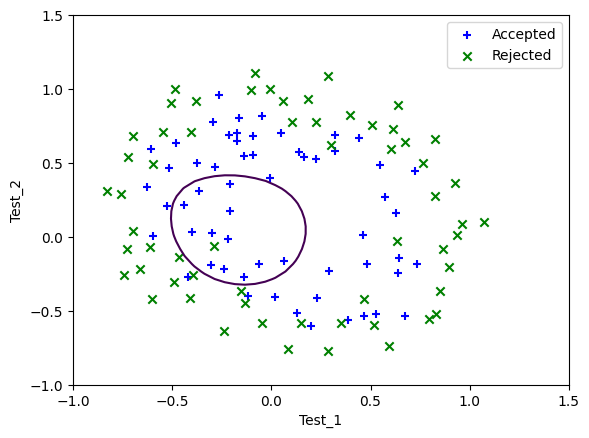

In [ ]:
import scipy.optimize as opt
result = opt.fmin_tnc(func = costFunctionR,
 x0 = theta, fprime = gradientFuncR,
 args = (X_poly, y, 100))
theta_optimized = result[0]

Accepted = df.loc[df['Pass'] == 1]
Rejected = df.loc[df['Pass'] == 0]

A = np.array(Accepted)[:,:2]
R = np.array(Rejected)[:,:2]

plt.scatter(A[:,0], A[:,1], color = 'b', label = "Accepted", marker='+');
plt.scatter(R[:,0], R[:,1], color = 'g', label = "Rejected", marker='x');


u = np.linspace(-1.0, 1.5, num=50)
v = np.linspace(-1.0, 1.5, num=50)
z = np.zeros((u.size, v.size))

for i in range(len(u)):
    for j in range(len(v)):
            z[i,j] = np.dot(polinomy(np.array([u[i]]), np.array([v[j]]), 6), theta_optimized)

z = np.transpose(z)

plt.contour(u, v, z, levels=[0]).collections[0]


plt.xlabel('Test_1')
plt.ylabel('Test_2')
plt.legend()
plt.show(block=False)

## 3. Использование логистической регрессии для решения задачи множественной классификации – распознавания рукописных цифр от 0 до 9


Загрузка данных

In [ ]:
df = pd.read_table("/content/ex2data3.txt", header = None, delimiter= ",")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Подготовка набора данных

In [ ]:
dff = np.array(df)
X = dff[:,:400]             # "Numbers" - pictures-matrix
y = dff[:,400].astype(int)              # Classes

theta = np.zeros((401, 1))
ones = np.ones(X.size)

m, n = X.shape
X_ = np.column_stack((np.ones((m,1)), X))

Минимизация функций

In [ ]:
import scipy.optimize as opt

m, n = X.shape
theta_optimized_all = np.zeros((10, n + 1))
print(theta_optimized_all.shape)

for i in range(10):
    new_theta = np.zeros((n + 1, 1))

    result = opt.fmin_tnc(func = costFunction,
    x0 = new_theta, fprime = gradientFunc,
    args = (X_, (y == i)))[0]
  #  theta_optimized = result[0]
    print(theta.shape)
    theta_optimized_all[i,:] = result

(10, 401)


<ipython-input-173-b65b86678347>:6: RuntimeWarning: divide by zero encountered in log
  J = -(1.0 / len(y)) * (y * np.transpose(np.log(h)) + (1 - y) * np.transpose(np.log(1 - h))).sum()
<ipython-input-173-b65b86678347>:6: RuntimeWarning: invalid value encountered in multiply
  J = -(1.0 / len(y)) * (y * np.transpose(np.log(h)) + (1 - y) * np.transpose(np.log(1 - h))).sum()


(401, 1)
(401, 1)
(401, 1)
(401, 1)
(401, 1)
(401, 1)
(401, 1)
(401, 1)


<ipython-input-173-b65b86678347>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


(401, 1)
(401, 1)


Выходные значения каждого из 10 классификаторов


In [ ]:
h = sigmoid(np.dot(X_, theta_optimized_all.T))
h.size

50000

 Выбор класса с максимальным значением вероятности принадлежности объекта к нему

In [ ]:
h_argmax = np.argmax(h, axis=1)
'''for i in h_argmax:
    print(i)'''


'for i in h_argmax:\n    print(i)'

Оценка точности модели
Алгоритм: Сравнение предсказанных значений с точными, выделение доли правильных ответов

In [ ]:
len(np.where(y == h_argmax)[0]) / len(y)

0.9722